### Use full_music_data and/or the two summary data sets (with artists and years) of music characteristics, to develop measures of music similarity. Using your measure, are artists within genre more similar than artists between genres?

In [20]:
import pandas as pd
import numpy as np
import networkx as nx
import ast
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from tqdm import tqdm

In [21]:
# load data into DataFrames
artists = pd.read_csv('data_by_artist.csv')
years = pd.read_csv('data_by_year.csv')
influence = pd.read_csv('influence_data.csv')
full = pd.read_csv('full_music_data.csv')
try:
    tqdm._instances.clear()
except AttributeError:
    pass

In [22]:
def scaleAttr(df, attr):
    """scales the attribute attr of the dataframe df to go from 0 to 1"""
    floor = min(df[attr])
    span = max(df[attr]) - floor
    df[attr] = [(x-floor)/span for x in df[attr]]

In [23]:
songStats = ['danceability', 'energy', 'valence', 'tempo', 'mode', 'acousticness', 'instrumentalness', 'speechiness']        
def artistSimilarity(a1, a2):
    a1Stats = artists[artists['artist_id'] == a1][songStats].to_numpy()
    a2Stats = artists[artists['artist_id'] == a2][songStats].to_numpy()
    if len(a1Stats) == 0 or len(a2Stats) == 0:
        return -1
    return float(cosine_similarity(a1Stats,a2Stats))

In [24]:
# scale tempo columns in each df
scaleAttr(full, 'tempo')
scaleAttr(artists, 'tempo')
scaleAttr(years, 'tempo')

# no dups
artists = artists.drop_duplicates(subset='artist_name', keep='last')

In [25]:
#remove songs by artists that arent in the artists table
#duplicate songs w/ more than one artist
#takes my computer about a minute to run
#can ignore the warnings about setting a copy of a slice from a dataframe
allArtists = list(artists['artist_id'])
newdict = {}

#parse id and name columns
full['artists_id'] = [int(x.split(',')[0][1:-1]) if len(x.split(',')) == 1 else [int(y) for y in x[1:-1].split(',')] for x in list(full['artists_id'])]
full['artist_names'] = [ast.literal_eval(x) if len(ast.literal_eval(x)) > 1 else ast.literal_eval(x)[0] for x in full['artist_names']]
scaleAttr(full, 'tempo')

last_id = 0
row = 0
for i in tqdm(range(len(full))): 
    thisRow = full.iloc[i,:].copy()
    artIDs = thisRow['artists_id']
    artNames = thisRow['artist_names']
    
    if type(artIDs) == int:
        if artIDs == last_id: 
            thisRow['artists_id'] = artIDs
            thisRow['artist_names'] = artNames
            newdict[row] = thisRow.to_dict()
            row+=1
            last_id = artIDs
        else:
            if artIDs in allArtists:
                thisRow['artists_id'] = artIDs
                thisRow['artist_names'] = artNames
                newdict[row] = thisRow.to_dict()
                row+=1
                last_id = artIDs
                
    else:
        for j in range(len(artIDs)):
            artID = int(artIDs[j])
            artName = str(artNames[j])
            
            if artID in allArtists:
                thisRow['artists_id'] = artID
                thisRow['artist_names'] = artName
                newdict[row] = thisRow.to_dict()
                row+=1
    i+=1

full = pd.DataFrame.from_dict(newdict,'index')

artistGenres = {} #adds song genre to full
for i in tqdm(range(len(influence))):
    row = influence.iloc[i]
    influencer = row['influencer_id']
    follower = row['follower_id']
    infGenre = row['influencer_main_genre']
    folGenre = row['follower_main_genre']
    artistGenres[influencer] = infGenre
    artistGenres[follower] = folGenre

def getGenre(row):
    artist = row['artists_id']
    if type(artist) == list:
        print(row)
    try:
        genre = artistGenres[artist]
    except KeyError:
        genre = 'N/A'
    return genre

full['genre'] = full.apply(lambda row: getGenre(row), axis = 1)
full

100%|██████████████████████████████████████████████████████████████████████████| 42770/42770 [00:07<00:00, 5645.82it/s]


,artist_names,artists_id,danceability,energy,valence,tempo,loudness,mode,key,acousticness,instrumentalness,liveness,speechiness,explicit,duration_ms,popularity,year,release_date,song_title (censored),genre
0,Fat Freddy's Drop,178301,0.600,0.365,0.131,0.532777,-13.083,0,9,0.06720,0.585000,0.0921,0.0498,0,437200,54,2005,2005,Ernie,Electronic
1,Fat Freddy's Drop,178301,0.874,0.326,0.179,0.490063,-13.302,0,11,0.01360,0.148000,0.0993,0.1310,0,581008,53,2005,2005,Wandering Eye,Electronic
2,Fat Freddy's Drop,178301,0.670,0.531,0.336,0.571037,-8.267,0,9,0.01560,0.345000,0.3060,0.0377,0,431293,55,2009,8/7/2009,The Raft,Electronic
3,Alexander O'Neal,625201,0.761,0.702,0.850,0.429237,-8.523,1,7,0.10800,0.000031,0.0935,0.0389,0,304427,34,1991,1/1/1991,All True Man,R&B;
4,Alexander O'Neal,625201,0.661,0.828,0.902,0.471455,-12.673,0,11,0.27600,0.000001,0.2870,0.0390,0,264933,37,1987,7/29/1987,(What Can I Say) To Make You Love Me,R&B;
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102913,ZZ Top,690254,0.276,0.892,0.715,0.329693,-7.035,1,11,0.40900,0.000000,0.7140,0.0893,0,115973,33,1975,4/18/1975,Jailhouse Rock - **** Remaster,Pop/Rock
102914,ZZ Top,690254,0.700,0.592,0.906,0.450025,-10.434,1,11,0.10800,0.018400,0.1180,0.0681,0,263627,32,1976,11/29/1976,It's Only Love,Pop/Rock
102915,ZZ Top,690254,0.709,0.709,0.863,0.456977,-12.023,1,2,0.11800,0.000011,0.1250,0.0370,0,158400,31,1987,1987,Balinese,Pop/Rock
102916,ZZ Top,690254,0.552,0.651,0.533,0.661835,-10.624,0,4,0.00494,0.034900,0.1320,0.2290,0,232533,43,1992,4/13/1992,La Grange - **** Remaster,Pop/Rock


In [26]:
# add edges to directed graph
# measure influence 

baseline = .9136464572663171 #from bullet 2 - average cosine similarity between a song and the era its from

idDict = {}
for i in tqdm(range(len(artists))):
    try:
        idDict[artists['artist_id'][i]] = artists['artist_name'][i]
    except KeyError:
        pass

influence = pd.read_csv('influence_data.csv')
iGraph = nx.DiGraph()

for artist in artists['artist_id']:
    iGraph.add_node(artist, weight = 0)
    
for i in tqdm(range(len(influence))):
    influencer = influence["influencer_id"][i]
    follower = influence['follower_id'][i]
    
    iGraph.add_edge(influencer,follower)    

artIDs = []
artNames = []
followers = []
grandFollowers = []
followerSimilarity = []

for i in tqdm(range(len(iGraph.nodes()))):
    node = list(iGraph.nodes())[i]
    
    children = list(iGraph.successors(node))
    nFollows = len(children)

    grandChildren = []
    similarity = 0
    for child in children:
        sim = artistSimilarity(node,child)
        if sim == -1:
            continue
        for grandChild in iGraph.successors(child):
            grandChildren.append(grandChild)
        similarity += sim
    
    artIDs.append(node)
    try:
        artNames.append(idDict[node])
    except KeyError:
        artNames.append('Unknown')
        
    followers.append(nFollows)
    grandFollowers.append(len(set(grandChildren)))
    try:
        followerSimilarity.append(similarity/nFollows)
    except ZeroDivisionError:
        followerSimilarity.append(0)
    
   
totalInfluence = pd.DataFrame({'artist_name':artNames, 'artist_id':artIDs, 'total_followers':followers,
                               '2nd_degree_followers':grandFollowers, 'follower_similarity':followerSimilarity})
totalInfluence = totalInfluence.reset_index(drop=True)
totalInfluence = totalInfluence.sort_values(by=['2nd_degree_followers'], ascending = False)
totalInfluence[:10]

100%|██████████████████████████████████████████████████████████████████████████████| 5853/5853 [01:58<00:00, 49.58it/s]


,artist_name,artist_id,total_followers,2nd_degree_followers,follower_similarity
15,The Beatles,754032,615,2690,0.936007
4,Bob Dylan,66915,389,2301,0.943389
5,The Rolling Stones,894465,319,1994,0.948397
128,Chuck Berry,120521,159,1952,0.931490
7,Elvis Presley,180228,166,1950,0.927962
167,Little Richard,824022,88,1858,0.933170
149,James Brown,128099,154,1763,0.932145
138,Jimi Hendrix,354105,201,1679,0.916628
377,Buddy Holly,538677,97,1643,0.952795
446,Bo Diddley,55128,65,1492,0.919290


In [27]:
genreCount = full.groupby('genre').count().iloc[:,1]
genreCount = genreCount[genreCount > 1500].sort_values(ascending = False)
genres = genreCount.index

songStats = ['danceability', 'energy', 'valence', 'tempo', 'acousticness', 'instrumentalness', 'speechiness']        

newDict = {}
for year in tqdm(range(1960,2021)):
    inYearRange = full[full['year'] <= year+5]
    inYearRange = inYearRange[inYearRange['year'] >= year-4]
    yearAvg = inYearRange.mean()[songStats].to_dict()
    newDict[year] = yearAvg
    for genre in genres:
        allInGenre = inYearRange[inYearRange['genre'] == genre]
        rollingAvg = allInGenre.mean()[songStats].to_dict()
        newDict[str(year)+genre] = rollingAvg
newDict
genreYears = pd.DataFrame.from_dict(newDict, orient = 'index')
genreYears


100%|██████████████████████████████████████████████████████████████████████████████████| 61/61 [00:54<00:00,  1.13it/s]


,danceability,energy,valence,tempo,acousticness,instrumentalness,speechiness
1960,0.497997,0.353581,0.533872,0.466586,0.732923,0.173674,0.062217
1960Pop/Rock,0.526124,0.538085,0.681055,0.493034,0.557971,0.077006,0.053438
1960R&B;,0.529068,0.448788,0.638903,0.481949,0.668678,0.017276,0.052308
1960Country,0.576126,0.386314,0.658763,0.477248,0.716622,0.068794,0.049508
1960Jazz,0.513521,0.291067,0.471702,0.458593,0.763527,0.330758,0.055787
...,...,...,...,...,...,...,...
2020Vocal,0.470250,0.479000,0.420250,0.464417,0.591500,0.000159,0.035525
2020Latin,0.716914,0.743189,0.670639,0.501694,0.209676,0.003136,0.109421
2020Classical,0.395333,0.172410,0.131000,0.513147,0.858667,0.601667,0.037567
2020N/A,0.639934,0.591479,0.467254,0.485165,0.224659,0.036164,0.108084


In [76]:
genreDiff = {}
for i in tqdm(range(len(full))):
    row = full.iloc[i]
    try:
        genre = artistGenres[row['artists_id']]
    except KeyError:
        continue
    
    year = row['year']
    if genre in genres and year >= 1960:
        baseline = np.array([genreYears.loc[year].to_numpy()])
        
        try:
            expStats = np.array([genreYears.loc[str(year)+genre].to_numpy()])
        except KeyError:
            continue
            
        stats = np.array([row[songStats].to_numpy()])
        baseDiff = float(cosine_similarity(stats,baseline))
        genDiff = float(cosine_similarity(stats,expStats))
        
        try:
            genreDiff['baseline'] = np.append(genreDiff['baseline'], baseDiff)
        except KeyError:
            genreDiff['baseline'] = np.array([baseDiff])
        
        try:
            genreDiff[genre][0] = np.append(genreDiff[genre][0],genDiff)
            genreDiff[genre][1] = np.append(genreDiff[genre][1],baseDiff)
        except KeyError:
            genreDiff[genre] = [np.array([genDiff]),np.array([baseDiff])]


100%|█████████████████████████████████████████████████████████████████████████| 102918/102918 [01:53<00:00, 910.36it/s]


{'baseline': array([0.95920191, 0.97782226, 0.93644152, ..., 0.96611976, 0.95186175,
        0.9713122 ]),
 'R&B;': [array([0.97333271, 0.97916972, 0.95284271, ..., 0.94919771, 0.9536635 ,
         0.96175203]),
  array([0.95920191, 0.97782226, 0.93644152, ..., 0.94425595, 0.91729408,
         0.92914588])],
 'Vocal': [array([0.93948058, 0.95441062, 0.98970251, ..., 0.99388895, 0.86181133,
         0.94499689]),
  array([0.87240934, 0.9778081 , 0.95259527, ..., 0.94306556, 0.65678401,
         0.6804647 ])],
 'Pop/Rock': [array([0.92727414, 0.97697225, 0.90195771, ..., 0.96796054, 0.96942352,
         0.97560829]),
  array([0.92373498, 0.96223249, 0.85580256, ..., 0.96611976, 0.95186175,
         0.9713122 ])],
 'Jazz': [array([0.88805543, 0.85588654, 0.91623872, ..., 0.90882537, 0.92703899,
         0.92940065]),
  array([0.97018382, 0.93569872, 0.99145683, ..., 0.98378472, 0.76927004,
         0.92126233])],
 'Country': [array([0.96858908, 0.95710979, 0.96049194, ..., 0.93934511, 0.9

In [77]:
for genre in list(genreDiff.keys()):
    genreDiff[genre][0] = np.mean(genreDiff[genre][0])
    genreDiff[genre][1] = np.mean(genreDiff[genre][1])
genreDiff

{'baseline': array([0.95920191, 0.97782226, 0.93644152, ..., 0.96611976, 0.95186175,
        0.9713122 ]),
 'R&B;': [0.9431010861439011, 0.9363033538353221],
 'Vocal': [0.9465373195158854, 0.8891212760031991],
 'Pop/Rock': [0.9197455982687481, 0.9157780479459726],
 'Jazz': [0.9080744203949581, 0.874273487293817],
 'Country': [0.9454420258012514, 0.9326838505318846],
 'Latin': [0.9483380131537296, 0.9358574725785689],
 'Reggae': [0.9583866543568348, 0.9344649068417161],
 'Classical': [0.9283443927537868, 0.7085839392649139]}

In [105]:
genreDiff['baseline'] = np.mean(genreDiff['baseline'])

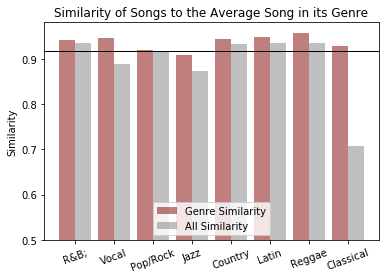

In [165]:
baseline = genreDiff['baseline']
labels = list(genreDiff.keys())[1:]
offset = .5
numbers1 = [genreDiff[x][0]-offset for x in labels]
numbers2 = [genreDiff[x][1]-offset for x in labels]

plt.plot(figsize=(12,12))
width = .4
rects1 = plt.bar(x - width/2, numbers1, width, label='Genre Similarity',bottom = offset, color = (.5,0,0,.5))
rects2 = plt.bar(x + width/2, numbers2, width, label='All Similarity',bottom = offset,color = (.5,.5,.5,.5))

plt.ylabel('Similarity')
plt.title('Similarity of Songs to the Average Song in its Genre')
plt.xticks(list(x),labels,rotation = 20)
plt.axhline(y=baseline,linewidth=1, color='k')
plt.legend(loc = 'lower center')
#plt.bar(labels,numbers,bottom = .8,  color=(0.4, 0.4, 0.6, 0.6))


In [29]:
allSongs = {}
for year in range(1960,2021):
    allSongs[year] = {}
for i in tqdm(range(len(full))):
    row = full.iloc[i]
    
    year = row['year']
    genre = row['genre']
    
    try:
        baseExp = np.array([genreYears.loc[year].to_numpy()])
        expStats = np.array([genreYears.loc[str(year)+genre].to_numpy()])
    except KeyError:
        continue
    stats = np.array([row[songStats].to_numpy()])
    
    diff = float(cosine_similarity(expStats,stats))
    bassDiff = float(cosine_similarity(baseExp,stats))
    
    try:
        allSongs[year][genre] = np.append(allSongs[year][genre],diff)
    except KeyError:
        allSongs[year][genre] = np.array([diff])
    
    try: 
        allSongs[year]['Total'] = np.append(allSongs[year]['Total'],bassDiff)
    except KeyError:
        allSongs[year]['Total'] = np.array([bassDiff])

songMeans = {}
for year in allSongs.keys():
    songMeans[year] = {}
    for genre in allSongs[year].keys():
        songMeans[year][genre] = np.mean(allSongs[year][genre])
genreSimilarities = pd.DataFrame.from_dict(songMeans,orient = 'index')

100%|█████████████████████████████████████████████████████████████████████████| 102918/102918 [01:51<00:00, 923.24it/s]


In [30]:
allSongs

{1960: {'Vocal': array([0.93948058, 0.95441062, 0.91661661, 0.97720739, 0.98458141,
         0.9502633 , 0.99072843, 0.98319862, 0.93047021, 0.97394076,
         0.98360913, 0.97702805, 0.98380246, 0.95476604, 0.98792908,
         0.94114659, 0.96366333, 0.96948883, 0.98744258, 0.95696543,
         0.91992502, 0.98639446, 0.99302443, 0.93996922, 0.90351014,
         0.95968327, 0.98087143, 0.97932211, 0.96853018, 0.94759914,
         0.98706978, 0.97958777, 0.97685972, 0.9787425 , 0.94317589,
         0.9829476 , 0.98723399, 0.98802561, 0.93724077, 0.98670334,
         0.94511034, 0.98997099, 0.95660178, 0.94231512, 0.98087363,
         0.97497249, 0.9716931 , 0.94442448, 0.96757565, 0.95677011,
         0.96893384, 0.97674134, 0.9852929 , 0.98186187, 0.97194914,
         0.92407078, 0.96386944, 0.93032458, 0.92825252, 0.85702345,
         0.92870218, 0.95631965, 0.93772497, 0.98993896, 0.9683813 ,
         0.91014859, 0.98837859, 0.98898716, 0.95367272, 0.97159472,
         0.93747325

In [31]:
def rollingaverage(array,rollsize):
    newarr = np.zeros(len(array))
    for i in range(len(array)):
        low = max(0,i-rollsize//2)
        high = min(len(array),i+rollsize//2+1)
        myarr = array[low:high]
        newval = np.nanmean(myarr)
        newarr[i] = newval
    return newarr

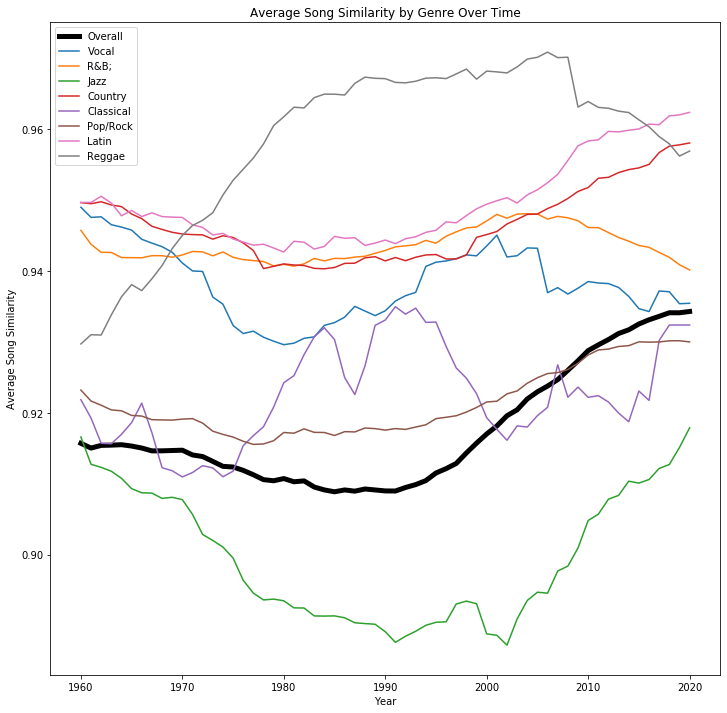

In [32]:
a = plt.figure(figsize = (12,12))
plt.plot(list(range(1960,2021)), rollingaverage(np.array(list(genreSimilarities['Total'])),20), label = 'Overall', linewidth = 5, color = 'black')
for column in list(genreSimilarities.columns):
    if column != 'N/A' and column != 'Total':
        toplot = rollingaverage(np.array(list(genreSimilarities[column])),20)
        plt.plot(list(range(1960,2021)),toplot, label = column)
plt.legend()
plt.xlabel("Year")
plt.ylabel("Average Song Similarity")
plt.title("Average Song Similarity by Genre Over Time")
plt.show()